# Drive mount

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/AN2DL/Competition2
%ls



/gdrive/MyDrive/AN2DL/Competition2
AuroregressiveForecasting0/   DirectForecasting3/
AuroregressiveForecasting1/   DirectForecasting30/
AuroregressiveForecasting10/  DirectForecasting31/
AuroregressiveForecasting11/  DirectForecasting32/
AuroregressiveForecasting12/  DirectForecasting33/
AuroregressiveForecasting13/  DirectForecasting34/
AuroregressiveForecasting14/  DirectForecasting35/
AuroregressiveForecasting15/  DirectForecasting36/
AuroregressiveForecasting16/  DirectForecasting37/
AuroregressiveForecasting18/  DirectForecasting38/
AuroregressiveForecasting19/  DirectForecasting39/
AuroregressiveForecasting2/   DirectForecasting4/
AuroregressiveForecasting20/  DirectForecasting40/
AuroregressiveForecasting21/  DirectForecasting41/
AuroregressiveForecasting22/  DirectForecasting42/
AuroregressiveForecasting23/  DirectForecasting43/
AuroregressiveForecasting24/  DirectForecasting44/
AuroregressiveForecasting26/  DirectForecasting45/
AuroregressiveForecasting28/  DirectForecasting46

# Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=20)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
from keras.layers import Layer
import keras.backend as K
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
!pip install attention
from attention import Attention

# Reproducibility seed

In [ ]:
#random
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Data

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [ ]:
print(columns)

Index(['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact',
       'Meme creativity', 'Soap slipperiness', 'Hype root'],
      dtype='object')


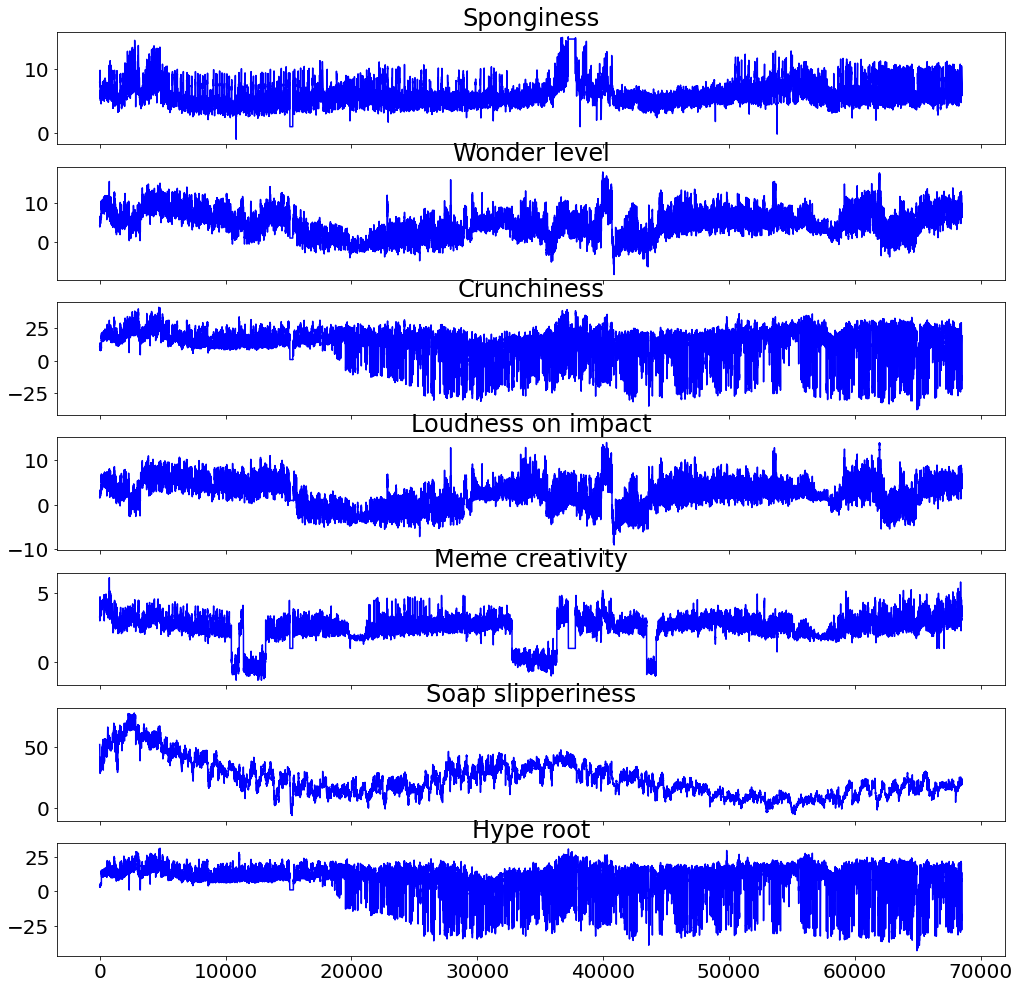

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True,figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col],color='blue' )
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(54823, 7) (13705, 7)
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64


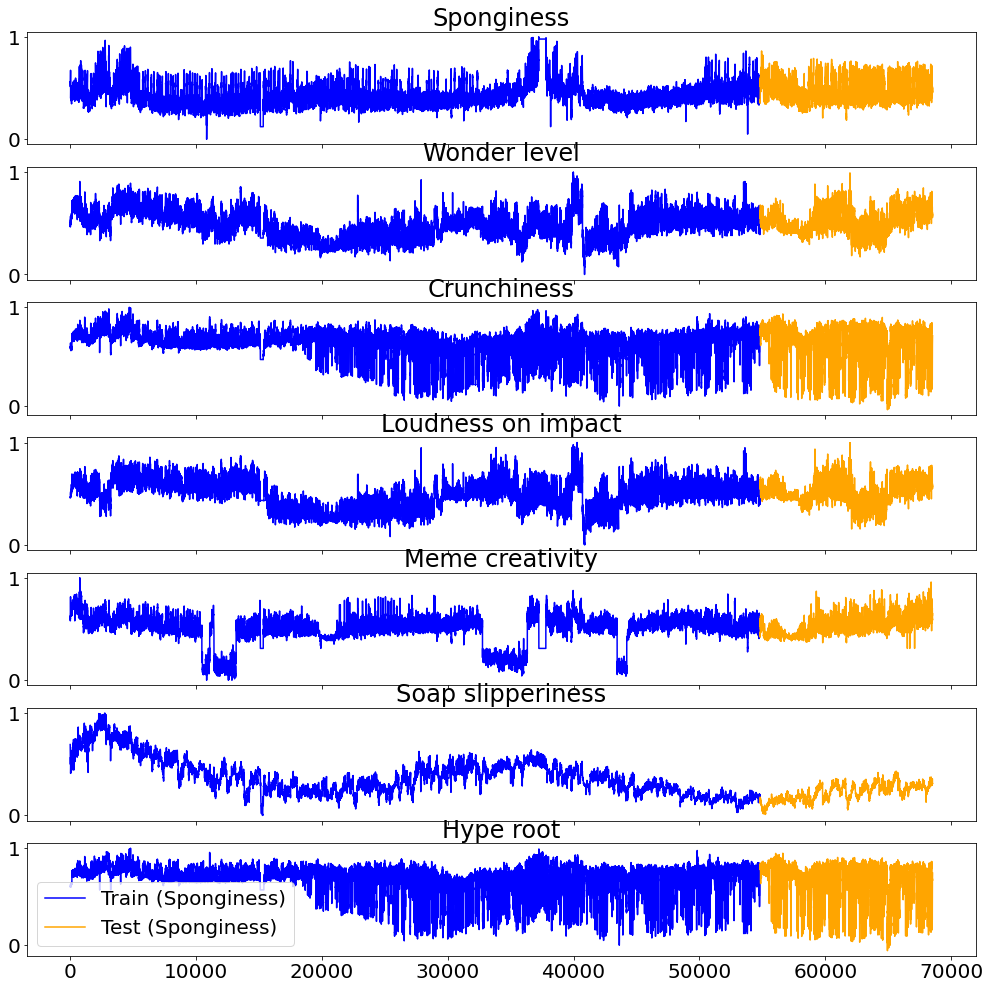

In [ ]:
test_size = int((dataset.shape[0])*0.2)
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()
print(X_min)
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)
columns=dataset.columns
figs, axs = plt.subplots(7, 1, sharex=True,figsize=(17,17))
for i, col in enumerate(columns):
  axs[i].plot(X_train_raw[col],color='blue' , label='Train (Sponginess)')
  axs[i].plot(X_test_raw[col],color='orange' , label='Test (Sponginess)')
  axs[i].set_title(col)
plt.legend()
plt.show()

In [ ]:
def build_sequences(df, target_labels=['Spoginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')#maybe32
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    #print(dataset)
    #print(labels)
    return dataset, labels

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,13))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()



# window,stride

In [ ]:
target_labels = dataset.columns
telescope = 864
window = 200
stride = 20
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2697, 200, 7), (2697, 864, 7), (637, 200, 7), (637, 864, 7))

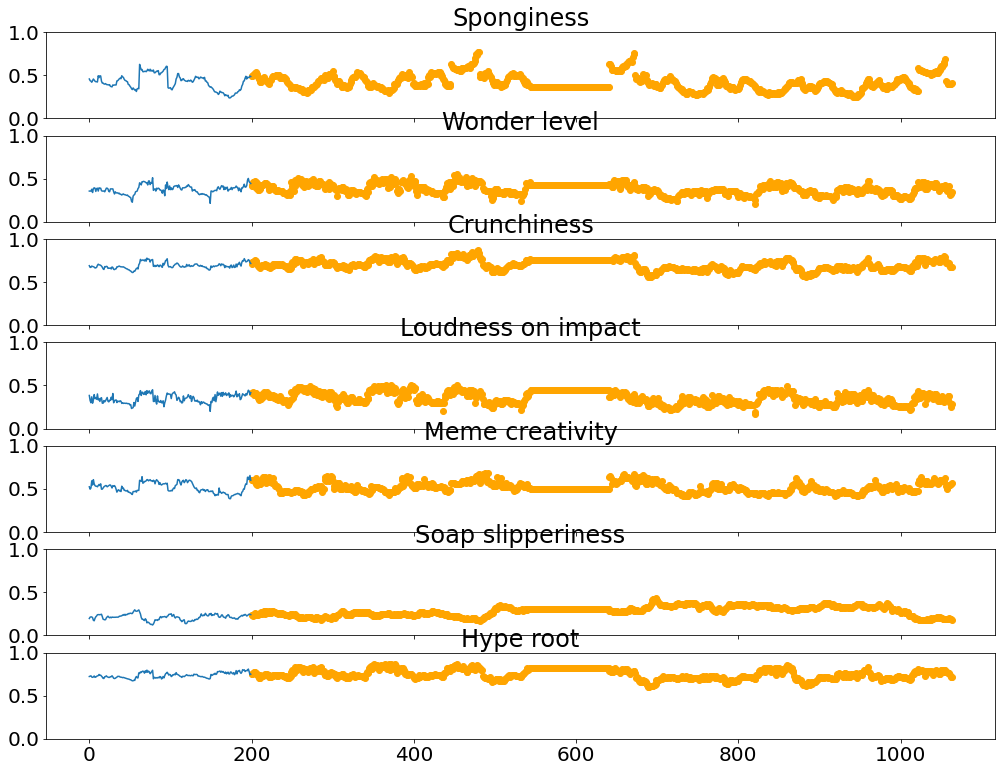

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

# attention1 end

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

(None, 200, 128)
(None, 200, 128)
(None, 100, 128)
(None, 100, 256)
(None, 100, 256)
(None, 256)
(None, 256)
(None, 6048)
(None, 864, 7)
(None, 864, 7)
(None, 7)
(None, 6048)
(None, 864, 7)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 128)         36864     
 nal)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 200, 128)          49280     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 100, 128)         0         
 1D)                                                             
                                                                 
 bi

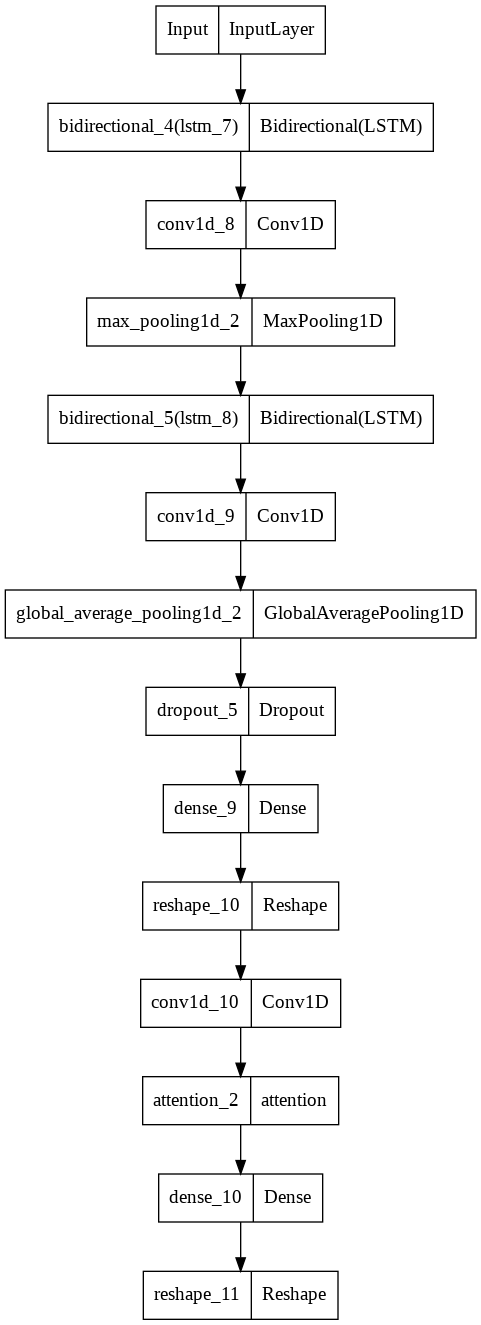

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #print(input_layer)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    #convlstm = Attention()(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.MaxPool1D()(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Dropout(.5)(convlstm)
    print(convlstm.shape)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension
    # [None, telescope, num_channels]
    #dense = tfkl.Dense(telescope*7, activation='relu')(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    print(dense.shape)

    #output_layer = tfkl.Reshape((864,7))(dense)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    print(output_layer.shape)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    print(output_layer.shape)

    output_layer = attention()(output_layer)
    print(output_layer.shape)
    output_layer = Dense(output_shape[-1]*output_shape[-2], activation='relu')(output_layer )
    print(output_layer.shape)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(output_layer)
    print(output_layer.shape)
    #print(output_layer)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model


input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
#batch_size = 64
#epochs = 20
#model = build_CONV_LSTM_model(input_shape, output_shape)
#model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

# attention1 start
(few parameters, But increase with window increase, suggested 10000)

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

(None, 7)
(None, 7)
(None, 6048)
(None, 864, 7)
(None, 864, 7)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 attention_3 (attention)     (None, 7)                 207       
                                                                 
 dropout_6 (Dropout)         (None, 7)                 0         
                                                                 
 dense_11 (Dense)            (None, 6048)              48384     
                                                                 
 reshape_12 (Reshape)        (None, 864, 7)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 864, 7)            56        
                                                                

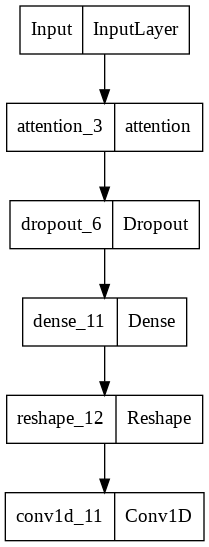

In [ ]:
def build_CONV_LSTM_modela(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #print(input_layer)

    convlstm = attention()(input_layer)
    print(convlstm.shape)
    convlstm = tfkl.Dropout(.5)(convlstm)
    print(convlstm.shape)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension
    # [None, telescope, num_channels]
    #dense = tfkl.Dense(telescope*7, activation='relu')(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    print(dense.shape)

    #output_layer = tfkl.Reshape((864,7))(dense)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    print(output_layer.shape)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    print(output_layer.shape)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model


input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
#batch_size = 64
#epochs = 20
#model = build_CONV_LSTM_modela(input_shape, output_shape)
#model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

# attention2 end

In [ ]:
class AAttention(Layer):

    def __init__(self, **kwargs):
        #self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28, philipperemy.
        """
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = Dot(axes=[1, 2], name='attention_score')([h_t, score_first_part])
        attention_weights = Activation('softmax', name='attention_weight')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1], name='context_vector')([hidden_states, attention_weights])
        pre_activation = Concatenate(name='attention_output')([context_vector, h_t])
        attention_vector = Dense(output_shape[-1]*output_shape[-2], use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

    #def get_config(self):
        #return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

(None, 200, 128)
(None, 200, 128)
(None, 100, 128)
(None, 100, 256)
(None, 100, 256)
(None, 256)
(None, 256)
(None, 6048)
(None, 864, 7)
(None, 864, 7)
(None, 6048)
(None, 864, 7)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 200, 7)]     0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 200, 128)    36864       ['Input[0][0]']                  
 )                                                                                                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 200, 128)     49280       ['bidirectional_6[0][0]']        
             

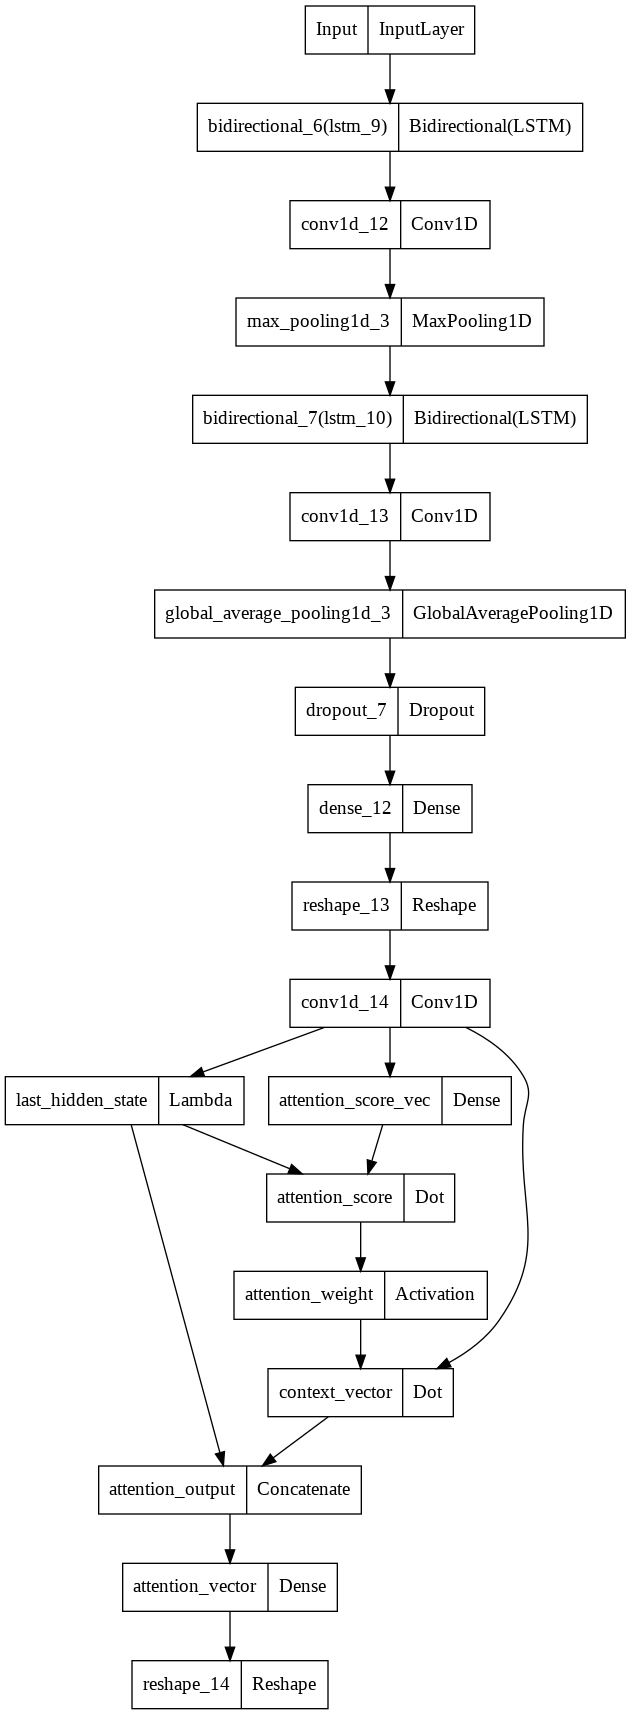

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #print(input_layer)

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    #convlstm = Attention()(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.MaxPool1D()(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    print(convlstm.shape)
    convlstm = tfkl.Dropout(.5)(convlstm)
    print(convlstm.shape)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension
    # [None, telescope, num_channels]
    #dense = tfkl.Dense(telescope*7, activation='relu')(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    print(dense.shape)

    #output_layer = tfkl.Reshape((864,7))(dense)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    print(output_layer.shape)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    print(output_layer.shape)

    output_layer = AAttention()(output_layer)
    print(output_layer.shape)

    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(output_layer)
    print(output_layer.shape)
    #print(output_layer)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model


input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
#batch_size = 64
#epochs = 20
#model = build_CONV_LSTM_model(input_shape, output_shape)
#model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

# attention2 start
(very few parameters, doesnt even increase with window increase)


In [ ]:
class AAttention(Layer):

    def __init__(self, **kwargs):
        #self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28, philipperemy.
        """
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = Dot(axes=[1, 2], name='attention_score')([h_t, score_first_part])
        attention_weights = Activation('softmax', name='attention_weight')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1], name='context_vector')([hidden_states, attention_weights])
        pre_activation = Concatenate(name='attention_output')([context_vector, h_t])
        attention_vector = Dense(output_shape[-1]*output_shape[-2], use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

    #def get_config(self):
        #return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

(None, 6048)
(None, 6048)
(None, 6048)
(None, 864, 7)
(None, 864, 7)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 200, 7)]     0           []                               
                                                                                                  
 last_hidden_state (Lambda)     (None, 7)            0           ['Input[0][0]']                  
                                                                                                  
 attention_score_vec (Dense)    (None, 200, 7)       49          ['Input[0][0]']                  
                                                                                                  
 attention_score (Dot)          (None, 200)          0           ['last_hidden_state[0][0]',      
                         

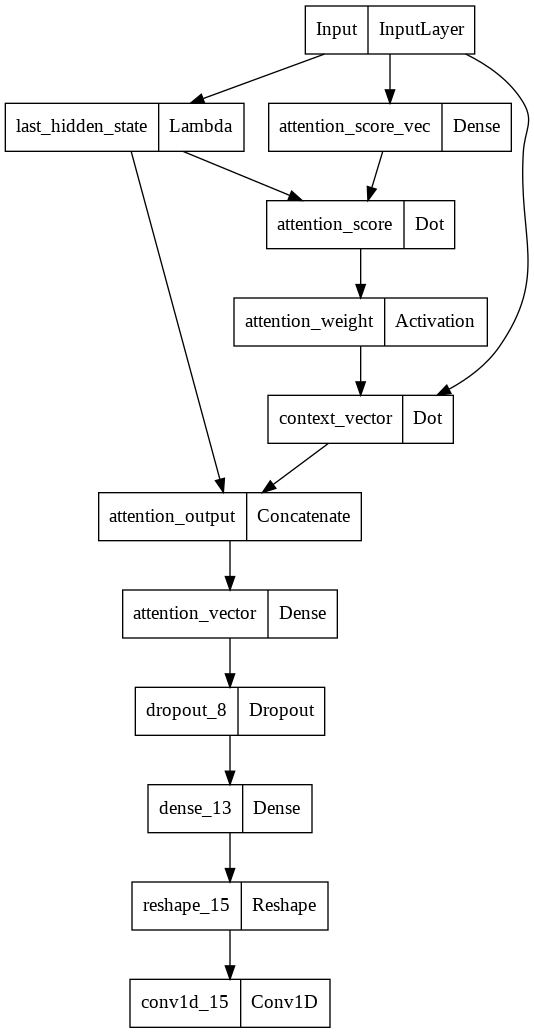

In [ ]:
def build_CONV_LSTM_modelAA(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #print(input_layer)

    convlstm = AAttention()(input_layer)
    print(convlstm.shape)
    convlstm = tfkl.Dropout(.5)(convlstm)
    print(convlstm.shape)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension
    # [None, telescope, num_channels]
    #dense = tfkl.Dense(telescope*7, activation='relu')(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    print(dense.shape)

    #output_layer = tfkl.Reshape((864,7))(dense)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    print(output_layer.shape)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    print(output_layer.shape)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model


input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
#batch_size = 64
#epochs = 20
#model = build_CONV_LSTM_modelAA(input_shape, output_shape)
#model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

# simple

In [ ]:
def build_simple_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tf.keras.layers.SimpleRNN(256, return_sequences=False)(input_layer)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension
    # [None, telescope, num_channels]
    #convlstm = tfkl.Dropout(.3)(convlstm)
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], kernel_initializer=tf.initializers.zeros())(convlstm)

    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    #output_layer = attention()(output_layer)
    #output_layer = tfkl.Dense(output_shape[-1]*output_shape[-2], kernel_initializer=tf.initializers.zeros())(output_layer)
    #output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

(200, 7) (864, 7)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               67584     
                                                                 
 dense_8 (Dense)             (None, 6048)              1554336   
                                                                 
 reshape_9 (Reshape)         (None, 864, 7)            0         
                                                                 
Total params: 1,621,920
Trainable params: 1,621,920
Non-trainable params: 0
_________________________________________________________________


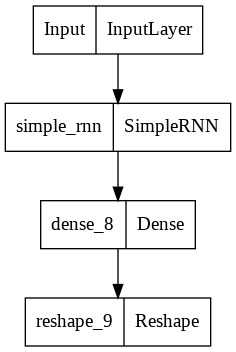

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
print(X_train.shape[1:], y_train.shape[1:])
model = build_simple_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# forecasting

In [ ]:
model.summary()
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               67584     
                                                                 
 dense_8 (Dense)             (None, 6048)              1554336   
                                                                 
 reshape_9 (Reshape)         (None, 864, 7)            0         
                                                                 
Total params: 1,621,920
Trainable params: 1,621,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
38/38 [==============================] - 9s 199ms/step - loss: 0.0459 - mae: 0.1570 - val_loss: 0.0226 - val_mae: 0.1244 - lr: 0.0010
Epoch 2/100
38/38 [==================

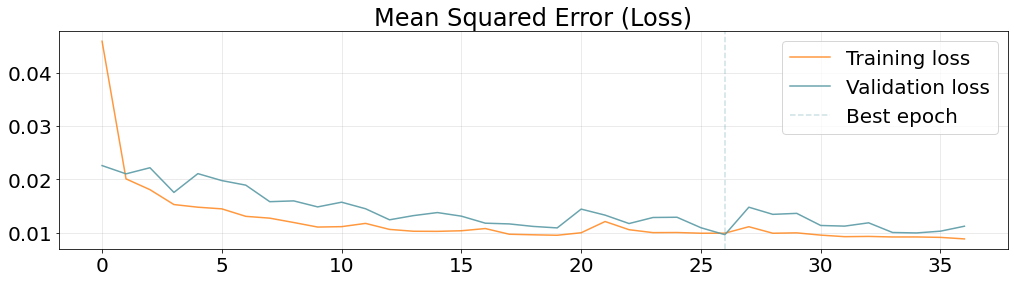

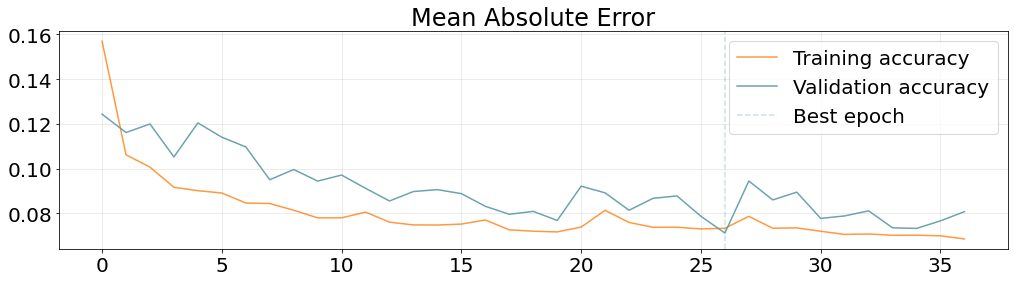

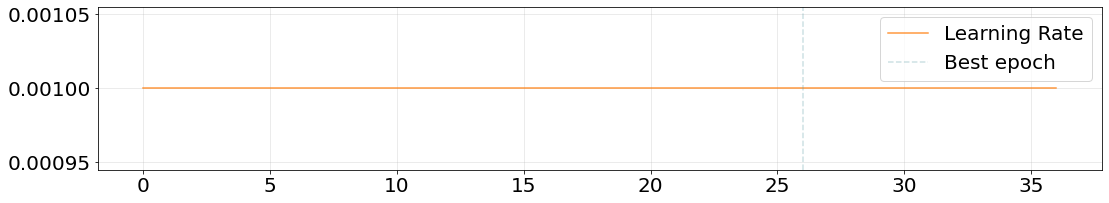

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('DirectForecastingFINAL')
model = tfk.models.load_model('DirectForecastingFINAL')